In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from joblib import Parallel, delayed
import time
import sys
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar

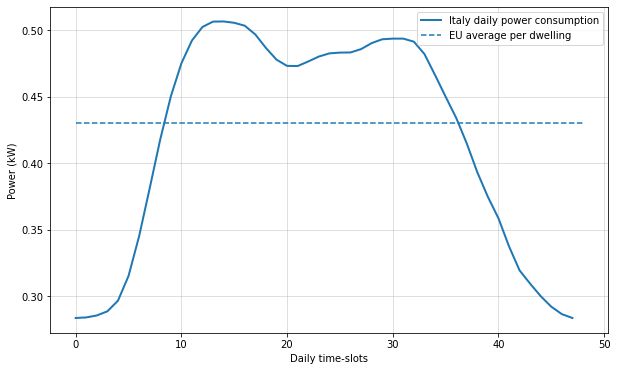

In [2]:
# Import the load profile
load_curve = np.loadtxt('data/load_agg_data.csv', delimiter=',', skiprows=1)[:, 2]
plt.figure(figsize=(10,6))
plt.plot(load_curve, lw=2, label='Italy daily power consumption')
plt.hlines(y=0.43, xmin=0, xmax=48, ls='dashed', label='EU average per dwelling')
plt.xlabel('Daily time-slots')
plt.ylabel('Power (kW)')
plt.grid(alpha=0.5)
plt.legend()

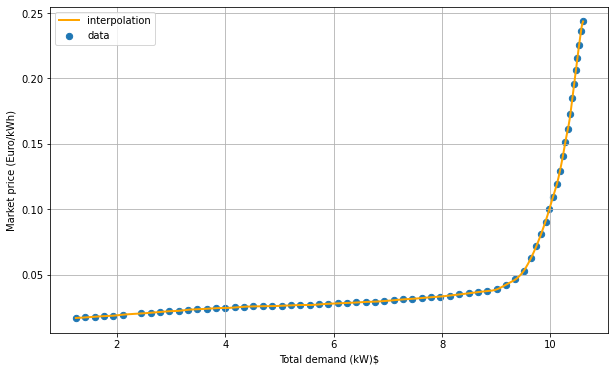

In [8]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 4.5 -9

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 600)
plt.figure(figsize=(10,6))
plt.scatter(tot_demand, market_price_data[:, 1] / 1000, s=40, label='data')
plt.plot(x, market_price(x), lw=2, label='interpolation', c='orange')
plt.xlabel(r'Total demand (kW)$')
plt.ylabel('Market price (Euro/kWh)')
plt.legend()
plt.grid()

### Functions

In [9]:
# Customer's utility function: for optimizing wrt b_pm
def u_b(b_pm, p, l, e):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    e: storage capacity 
    """
    return np.sum(p * (b_pm[:T] - b_pm[T:] + l))

def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        mat1[0, j] = -alpha
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat4[i, :i] = -alpha
        mat4[i, T:T+i] = alpha
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5, mat3])

def constr_vectors_b(b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5, leftv3])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [alpha * e0] * T, [e - e0] * T, l])
    return leftv_constr, rightv_constr

def optimize_b(b_sup, b_inf, p, alpha, e0, e, l):
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    x0 = np.zeros(2 * T)
    b_opt = minimize(u_b, x0, args=(p, l, e), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        options={'verbose' : 0})
    return b_opt.x

### Parameters

In [10]:
n_nodes = 20
T = 48                                      # number of time slots in a day(1 slot = 0.5 hours)
n_days = 10                                 # number of days to simulate 
beta = 0.05                                 # storage profile learning rate
b_inf = 0.2                                 # Maximum discharge in a time slot (kWh)
b_sup = 0.2                                 # Maximum charge in a time slot(kWh)
alpha = 0.8                                 # efficiency

In [11]:
# Intialization
e0 = np.ones(n_nodes)*0.                # storage level
e = 5.                                  # storage capacity
b_pm = np.zeros(shape=(n_nodes, 2*T))   # charging profiles
l = np.zeros(shape=(n_nodes, T))        # load profiles
b_history = np.ndarray(shape=(0, T))    # storage profile history
p_history = np.ndarray(shape=(0, T))    # price history

# generate load profiles
sigma = 0.005
for i in range(n_nodes):
    l[i, :] = load_curve[(poisson.rvs(mu=2, size=T) + np.arange(T)) % T] + np.random.randn(T)*sigma

p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
p_history = np.append(p_history, [p], axis=0)

### Simulation

In [12]:
for d in range(n_days):
    t_start = time.time()
    profiles = np.ndarray((n_nodes, T))
    b_opt = np.ndarray(shape=(0, 2*T))

    # optimize b
    with Parallel(n_jobs=n_nodes) as parallel:
        b_opt_list = parallel(delayed(optimize_b)(b_sup, b_inf, p, alpha, e0[n], e, l[n, :]) for n in range(n_nodes))
    for n in range(n_nodes):
        b_opt = np.append(b_opt, [b_opt_list[n]], axis=0)

    # update b
    b_pm = b_pm + beta * (b_opt - b_pm)

    # update e0
    e0 = e0 + b_pm[:, :T].sum() - b_pm[:, T:].sum()

    b_history = np.append(b_history, [np.mean(b_pm[:, :T] - b_pm[:, T:], axis=0)], axis=0)
    p = market_price(l.sum(axis=0) - b_pm[:, T:].sum(axis=0) + b_pm[:, :T].sum(axis=0))
    p_history = np.append(p_history, [p], axis=0)
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))

completed day 1/10 in 0.13 min
completed day 2/10 in 0.07 min
completed day 3/10 in 0.07 min
completed day 4/10 in 0.07 min
completed day 5/10 in 4.18 min
completed day 6/10 in 4.11 min
completed day 7/10 in 4.1 min
completed day 8/10 in 4.4 min
completed day 9/10 in 0.06 min
completed day 10/10 in 0.06 min


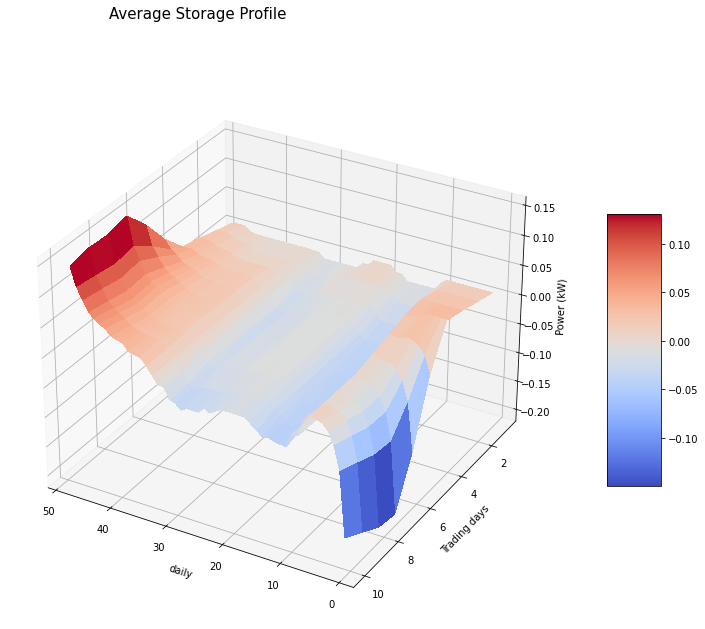

In [13]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,10))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Power (kW)', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Average Storage Profile', size=15);

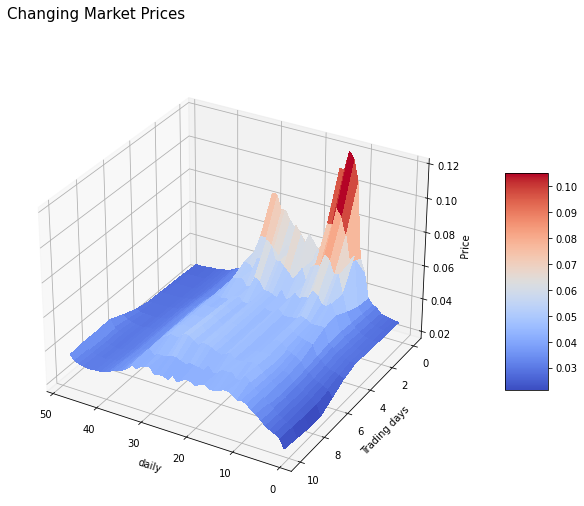

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20,8))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_ylabel('Trading days', size=10)
ax.set_xlabel('daily', size=10)
ax.set_zlabel('Price', size=10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
fig.suptitle('Changing Market Prices', size=15);